In [1]:
import torch
from torch_geometric.data import Data, Dataset
import networkx as nx
from networkx.algorithms.centrality import betweenness_centrality

from Datasets.synthetics import BA_2grid, BA_2grid_house, ProbingDataset, BA_2grid_to_test
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

import torch_geometric.utils as pyg_utils
import networkx as nx
from networkx.algorithms.centrality import betweenness_centrality

import pickle as pkl
from torch_geometric.utils import from_networkx
import random

from models.models_BA_2grid import GCN_framework as framework
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch.optim as optim

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def set_seed(seed):
    if seed == -1:
        seed = random.randint(0, 1000)
    # Pandas also uses np random state by default
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # if you are using GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [4]:
set_seed(43)

# Compute Graph-Features Dataset

The features for BA-2grid-house and ER-nb_stars2 datasets:
- num_nodes
- num_edges
- density
- average_shortest_path_length
- transitivity
- average_clustering

In [5]:
probing_dataset = ProbingDataset()

In [6]:
probing_dataset

ProbingDataset(2000)

In [7]:
gnn_dataset_to_test = BA_2grid_to_test()

In [8]:
idx = torch.arange(len(gnn_dataset_to_test))
train_idx, test_idx = train_test_split(idx, train_size=0.8,random_state=10)

train_loader = DataLoader(gnn_dataset_to_test[train_idx],batch_size=256)
test_loader = DataLoader(gnn_dataset_to_test[test_idx],batch_size=256)

In [9]:
# Assuming you have a list of graphs in your dataset
idx = torch.arange(len(probing_dataset))
train_idx, test_idx = train_test_split(idx, train_size=0.8,random_state=10)

probe_train_loader = DataLoader(probing_dataset[train_idx],batch_size=256)
probe_test_loader = DataLoader(probing_dataset[test_idx],batch_size=256)

# Load Model to Probe

In [10]:
MODEL = "GCN"
DATASET = "BA_2grid"
dataset = BA_2grid()
gnn = framework(dataset,device="cpu")

/home/mara/anaconda3/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [11]:
# train the model
gnn.train()

0.6991686612894952

# Train probe

In [12]:
class Probe(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Probe, self).__init__()
        self.fc = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.fc(x.float())
        return out

In [13]:
def train_probe(probe, gnn, layer_idx):
    gnn.model.eval()
    probe.train()
    
    total_loss = 0
    loss_fn = torch.nn.MSELoss()
    optimizer = optim.Adam(probe.parameters(), lr=0.001)

    for graph in probe_train_loader:

        optimizer.zero_grad()
        output = gnn.model(graph.x, graph.edge_index, graph.batch)
        output = torch.sum(output, dim=1)
        labels = graph.y.reshape(int(len(graph.y)/6), 6)
        padded_output = torch.nn.functional.pad(output, (0, 256 - int(len(graph.y)/6)))
        output = probe(padded_output)
        
        
        loss = loss_fn(output, labels)
        loss.backward()

        optimizer.step()
        
        total_loss += float(loss) * graph.num_graphs
    return total_loss / len(probe_train_loader.dataset)

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_probe(probe, test_loader):
    probe.eval()

    mse = 0
    r2 = 0
    total = 0
    loss_fn = torch.nn.MSELoss()
    
    for graph in test_loader:

        output = gnn.model(graph.x, graph.edge_index, graph.batch)
        output = torch.sum(output, dim=1)
        y_true = graph.y.reshape(int(len(graph.y)/6), 6)
        padded_output = torch.nn.functional.pad(output, (0, 256 - int(len(graph.y)/6)))
        y_pred = probe(padded_output)

        mse += loss_fn(y_pred, y_true)
        # r2 += r2_score(y_true, y_pred)
        total += 1
    
    return {
        "MSE": mse/total
        # "R2 Score": r2/total
    }

In [15]:
def iterate_to_train(gnn, layer_idx, num_epochs=10):
    probe = Probe(256, 6)
    losses = []
    test_losses = []
    for epoch in range(num_epochs):
        loss = train_probe(probe, gnn, layer_idx)
        losses.append(loss)
        result = evaluate_probe(probe, probe_test_loader)
        test_acc = result['MSE']
        test_losses.append(test_acc)
        print(f'Epoch: {epoch:03d}, '
              f'Test MSE: {test_acc:.3f}',
              f'Train MSE: {loss:.3f}')
        # print(f'Epoch: {epoch:03d}, '
        #       f'Loss: {loss:.3f}, ')
    return probe, losses, test_losses

In [16]:
probe, losses, test_acc = iterate_to_train(gnn, 0, num_epochs=100)

/home/mara/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([256, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mara/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mara/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([144, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch: 000, Test MSE: 227.346 Train MSE: 233.254
Epoch: 001, Test MSE: 212.227 Train MSE: 214.217
Epoch: 002, Test MSE: 197.887 Train MSE: 196.312
Epoch: 003, Test MSE: 184.328 Train MSE: 179.532
Epoch: 004, Test MSE: 171.595 Train MSE: 163.826
Epoch: 005, Test MSE: 159.317 Train MSE: 148.936
Epoch: 006, Test MSE: 147.609 Train MSE: 134.801
Epoch: 007, Test MSE: 136.375 Train MSE: 121.423
Epoch: 008, Test MSE: 125.705 Train MSE: 108.800
Epoch: 009, Test MSE: 115.513 Train MSE: 96.934
Epoch: 010, Test MSE: 105.884 Train MSE: 85.824
Epoch: 011, Test MSE: 96.735 Train MSE: 75.472
Epoch: 012, Test MSE: 88.147 Train MSE: 65.875
Epoch: 013, Test MSE: 80.042 Train MSE: 57.036
Epoch: 014, Test MSE: 72.498 Train MSE: 48.952
Epoch: 015, Test MSE: 65.439 Train MSE: 41.626
Epoch: 016, Test MSE: 58.941 Train MSE: 35.056
Epoch: 017, Test MSE: 52.931 Train MSE: 29.243
Epoch: 018, Test MSE: 47.483 Train MSE: 24.184
Epoch: 019, Test MSE: 42.526 Train MSE: 19.881
Epoch: 020, Test MSE: 38.134 Train MSE: 

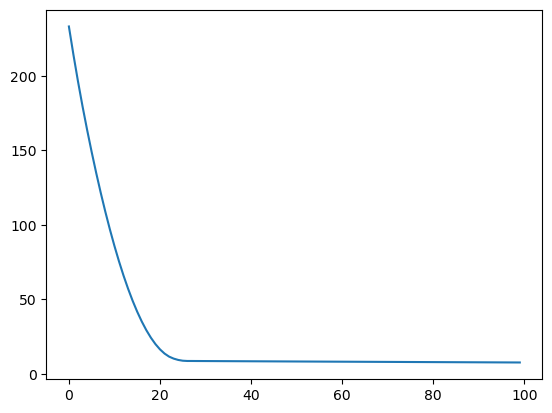

In [17]:
import matplotlib.pyplot as plt
epochs = [i for i in range(100)]
plt.plot(epochs, losses)

In [17]:
gnn.model.eval()
loss_fn = torch.nn.MSELoss()
mse = 0
total = 0 
r2_scores = []
for graph in train_loader:
    output = gnn.model(graph.x, graph.edge_index, graph.batch)
    output = torch.sum(output, dim=1)
    y_true = graph.y.reshape(int(len(graph.y)/6), 6)
    padded_output = torch.nn.functional.pad(output, (0, 256 - int(len(graph.y)/6)))
    y_pred = probe(padded_output)
    
    mse += loss_fn(y_pred, y_true)
    total += 1

    # Calculate R2 score per property
    r2_per_property = []
    y_true = y_true.T
    for i in range(len(y_true)):
        predictions = y_pred[i].detach().numpy().repeat(len(y_true[i]))
        r2 = r2_score(y_true[i], predictions)
        r2_per_property.append(r2)
    r2_scores.append(r2_per_property)

r2_scores = np.mean(r2_scores, axis=0)
print(mse/total)
print(r2_scores)

tensor(19.9823, grad_fn=<DivBackward0>)
[-1.59017107 -2.01624809 -0.79297536 -0.97102047  0.          0.        ]


/home/mara/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([256, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mara/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([256, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mara/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([256, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

In [21]:
gnn.model.eval()
loss_fn = torch.nn.MSELoss()
mse = 0
total = 0 
r2_scores = []
for graph in train_loader:
    output = gnn.model(graph.x, graph.edge_index, graph.batch)
    output = torch.sum(output, dim=1)
    y_true = graph.y.reshape(int(len(graph.y)/6), 6)
    padded_output = torch.nn.functional.pad(output, (0, 256 - int(len(graph.y)/6)))
    y_pred = probe(padded_output)
    
    mse += loss_fn(y_pred, y_true)
    total += 1

    # Calculate R2 score per property
    r2_per_property = []
    for i in range(len(y_true)):
        r2 = r2_score(y_true[i], y_pred.detach().numpy())
        r2_per_property.append(r2)
    
    r2_per_property = np.mean(r2_per_property)
    r2_scores.append(r2_per_property)

# r2_scores = np.mean(r2_scores, axis=0)
print(mse/total)
print(np.mean(r2_scores))
print(r2_scores)

/home/mara/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([256, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mara/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([256, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mara/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([256, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

tensor(19.9823, grad_fn=<DivBackward0>)
0.7556661984785487
[0.8324555307414964, 0.7941675084346029, 0.8303284134234526, 0.8234154997963283, 0.7925062498514386, 0.7960124544203672, 0.4207777326821539]
